In [1]:
from google.colab import drive
drive.mount("/content/drive/")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
# notes: scanpy has several versions, afer 17May2020, it become 1.5.1 from 1.4.6
!pip install scanpy
!pip install leidenalg

In [0]:
#!pip install bbknn==1.3.6
#!pip install umap-learn==0.3.9

In [0]:
import h5py
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from cycler import cycler


In [5]:
# notice that scanpy already became 1.5.1 after 17May2020
sc.settings.verbosity = 3 
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, figsize=(4, 4))

scanpy==1.5.1 anndata==0.7.3 umap==0.4.3 numpy==1.18.4 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.10.2 python-igraph==0.8.2 leidenalg==0.8.0


In [0]:
import os
os.chdir("/content/drive/Shared drives/CARD/projects/iNDI/line_prioritization/projects_lirong/Florian_data")

In [0]:
adata = sc.read_h5ad("florian_concat_leiden.h5ad")

In [0]:
adata

AnnData object with n_obs × n_vars = 60832 × 2954
    obs: 'donor_label', 'batch', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'leiden', 'leiden_0.6', 'leiden_0.4', 'leiden_0.2', 'leiden_0.1'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'batch_colors', 'leiden', 'leiden_0.6_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

# Calculate the percentage of cells for a specific cluster for a specific donors

In [0]:
df_all = adata.obs.loc[:, ["donor_label","batch","leiden_0.6"]]

In [69]:
df_all["leiden"] = df_all["leiden_0.6"]
#df["cell_count"] = 1
df_all.head()

,donor_label,batch,leiden_0.6,leiden
AAACCCAAGCAAATGT-1-cortical_1,LNGPI1-C1,cortical_1,15,15
AAACCCAAGGATGGCT-1-cortical_1,NN0003932-C3,cortical_1,14,14
AAACCCAAGTGCTACT-1-cortical_1,PGP1-C2,cortical_1,4,4
AAACCCACAGGACATG-1-cortical_1,PGP1-C2,cortical_1,4,4
AAACCCACATCTTTCA-1-cortical_1,KOLF2-ARID2-A02,cortical_1,1,1


### Check the clusters composition for all donors by sample

In [98]:
df_all_cluster = df_all.reset_index()
df_all_cluster.drop(["donor_label","leiden"], axis=1, inplace=True)
df_all_cluster.columns = ["cell", "batch", "leiden"]
df_all_cluster.head()

,cell,batch,leiden
0,AAACCCAAGCAAATGT-1-cortical_1,cortical_1,15
1,AAACCCAAGGATGGCT-1-cortical_1,cortical_1,14
2,AAACCCAAGTGCTACT-1-cortical_1,cortical_1,4
3,AAACCCACAGGACATG-1-cortical_1,cortical_1,4
4,AAACCCACATCTTTCA-1-cortical_1,cortical_1,1


In [0]:
df_all_cluster1 = df_all_cluster.pivot_table(index="leiden", columns="batch", values = "cell", aggfunc="count").fillna(0).astype("int")

In [100]:
df_all_cluster2 = df_all_cluster.pivot_table(index="batch", columns="leiden", values = "cell", aggfunc="count").fillna(0).astype("int")
df_all_cluster2

leiden,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
batch,,,,,,,,,,,,,,,,,,,,,,,
cortical_1,0,3075,2,1,1739,0,0,1674,7,14,1249,1142,0,4,802,769,84,0,12,0,0,3,1
cortical_2,0,3456,6,2,2099,0,1,1673,5,5,1196,1290,0,14,861,826,85,0,18,0,0,0,0
dopaminergic_1,3987,1,2047,0,0,0,1609,0,1,0,0,0,1135,0,3,0,60,527,0,147,129,52,27
dopaminergic_2,4338,1,2332,0,0,1,1852,0,0,0,0,0,1243,0,2,0,41,516,0,164,135,51,31
hypothalamic_1,2,4,2,2243,0,2044,3,2,1635,1310,0,0,0,792,7,6,457,0,420,0,0,0,0
hypothalamic_2,4,1,5,2103,2,1673,1,5,1591,1586,4,0,1,1147,18,5,794,5,412,0,0,0,1


In [0]:
def draw_stackbar(df_cor, sample_name):
  donor_name = df_cor.index.to_list()
  cluster_name = df_cor.columns.to_list()

  bar_l = range(len(donor_name))
  num_column =len(cluster_name)
  cm = plt.get_cmap('nipy_spectral')

  f, ax = plt.subplots(1, figsize=(8,6),dpi=100)
  ax.set_prop_cycle(cycler('color',[cm(1.*i/num_column) for i in range(num_column)]))

  bottom = np.zeros_like(bar_l).astype('float')
  for i, col in enumerate(cluster_name):
      ax.bar(df_cor.index, df_cor[col], bottom = bottom, label=col)
      bottom += df_cor[col].values
  ax.grid(False)
  ax.set_title(sample_name)
  ax.set_xticks(bar_l)
  ax.set_xticklabels(donor_name, rotation=45)
  ax.legend(loc="upper left", bbox_to_anchor=(1,1), ncol=2, fontsize='small')
  f.subplots_adjust(right=0.75, bottom=0.4)
  f.show()

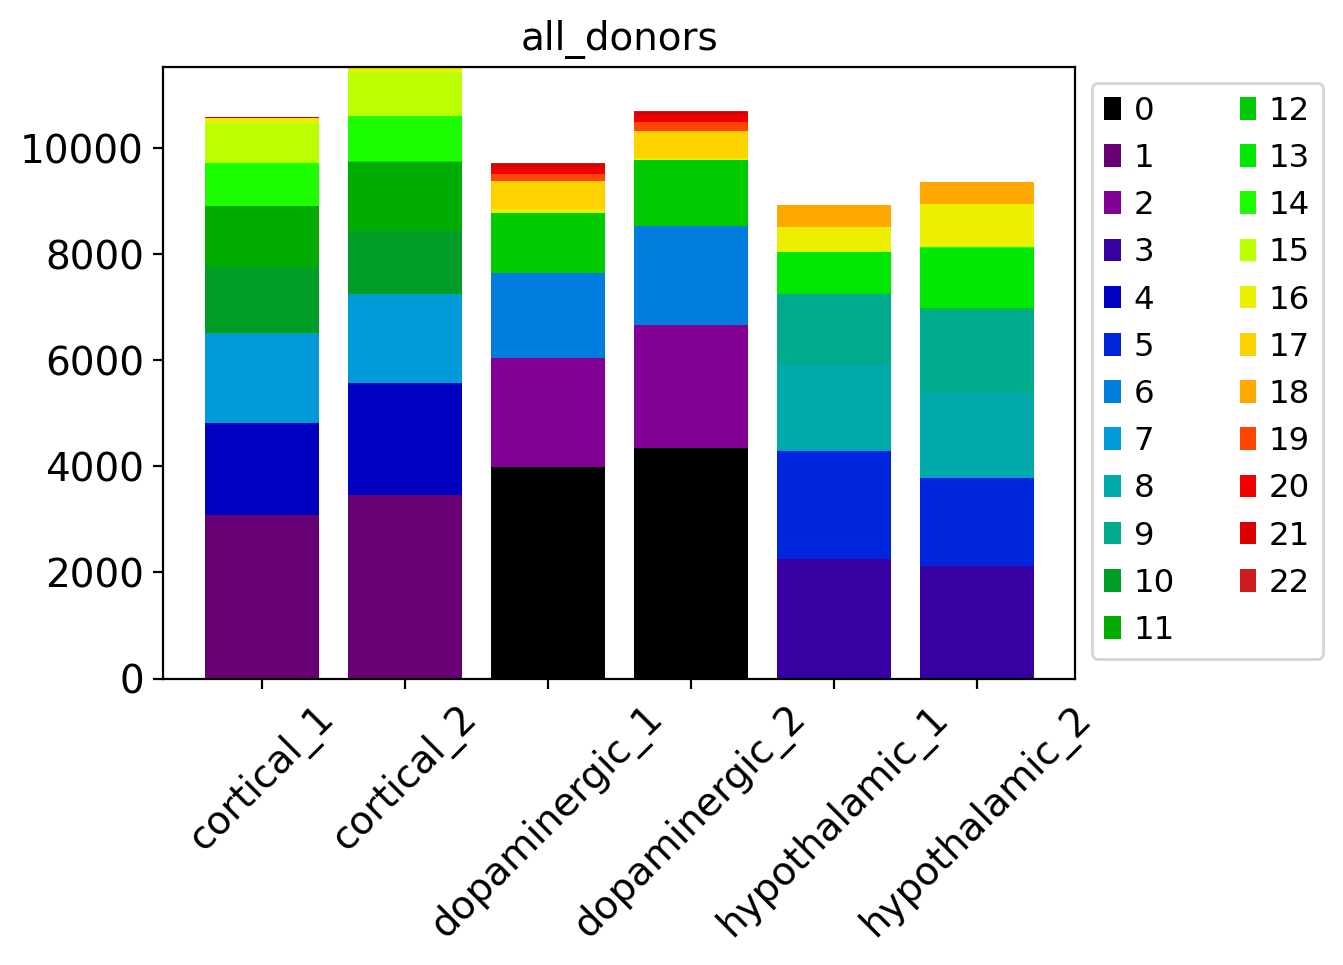

In [102]:
# draw stack bar
draw_stackbar(df_all_cluster2, "all_donors")

# Extrac the data of KOLF2

In [70]:
df_kolf2 = df_all[df_all["donor_label"]=="KOLF2-ARID2-A02"]
df_kolf2.shape

(5947, 4)

In [71]:
df_kolf2 = df_kolf2.reset_index()
df_kolf2.drop(["donor_label","leiden"], axis=1, inplace=True)
df_kolf2.columns = ["cell", "batch", "leiden"]
df_kolf2.head()

,cell,batch,leiden
0,AAACCCACATCTTTCA-1-cortical_1,cortical_1,1
1,AAACCCATCGTCCTCA-1-cortical_1,cortical_1,1
2,AAACGAAGTTTCGTGA-1-cortical_1,cortical_1,1
3,AAAGGATGTCCCTGAG-1-cortical_1,cortical_1,7
4,AAAGGGCGTTGGCCTG-1-cortical_1,cortical_1,1


In [188]:
df_kolf2.leiden.value_counts()

1     1157
5      765
0      570
7      516
3      390
14     342
11     337
6      274
2      261
4      246
10     241
15     201
17     123
13     120
12     111
16     107
8      103
18      58
9       13
19      10
20       1
22       1
21       0
Name: leiden, dtype: int64

In [0]:
df_kolf2_1 = df_kolf2.copy()

In [182]:
df_kolf2_1 = df_kolf2_1.rename({"leiden": "leiden_0.6"},axis=1)
df_kolf2_1.head()

,cell,batch,leiden_0.6
0,AAACCCACATCTTTCA-1-cortical_1,cortical_1,1
1,AAACCCATCGTCCTCA-1-cortical_1,cortical_1,1
2,AAACGAAGTTTCGTGA-1-cortical_1,cortical_1,1
3,AAAGGATGTCCCTGAG-1-cortical_1,cortical_1,7
4,AAAGGGCGTTGGCCTG-1-cortical_1,cortical_1,1


In [186]:
#df_kolf2_1 = df_kolf2_1.groupby(["batch", "leiden_0.6"]).count()
df_kolf2_1 = df_kolf2_1.fillna(0).astype('int')
df_kolf2_1.head()

cell
batch      leiden_0.6      
cortical_1 0              0
           1            541
           2              0
           3              0
           4            118

In [189]:
df_kolf2_1

cell
batch          leiden_0.6      
cortical_1     0              0
               1            541
               2              0
               3              0
               4            118
...                         ...
hypothalamic_2 18            35
               19             0
               20             0
               21             0
               22             1

[138 rows x 1 columns]

In [0]:
df_kolf2_1.to_csv("counts_byCluster_byProtocol_florian_kolf2.csv")

# Calculate the percentage of clusters for each protocol only for KOLF2

In [0]:
df_cluster = df_kolf2.pivot_table(index="leiden", columns="batch", values = "cell", aggfunc="count").fillna(0).astype("int")

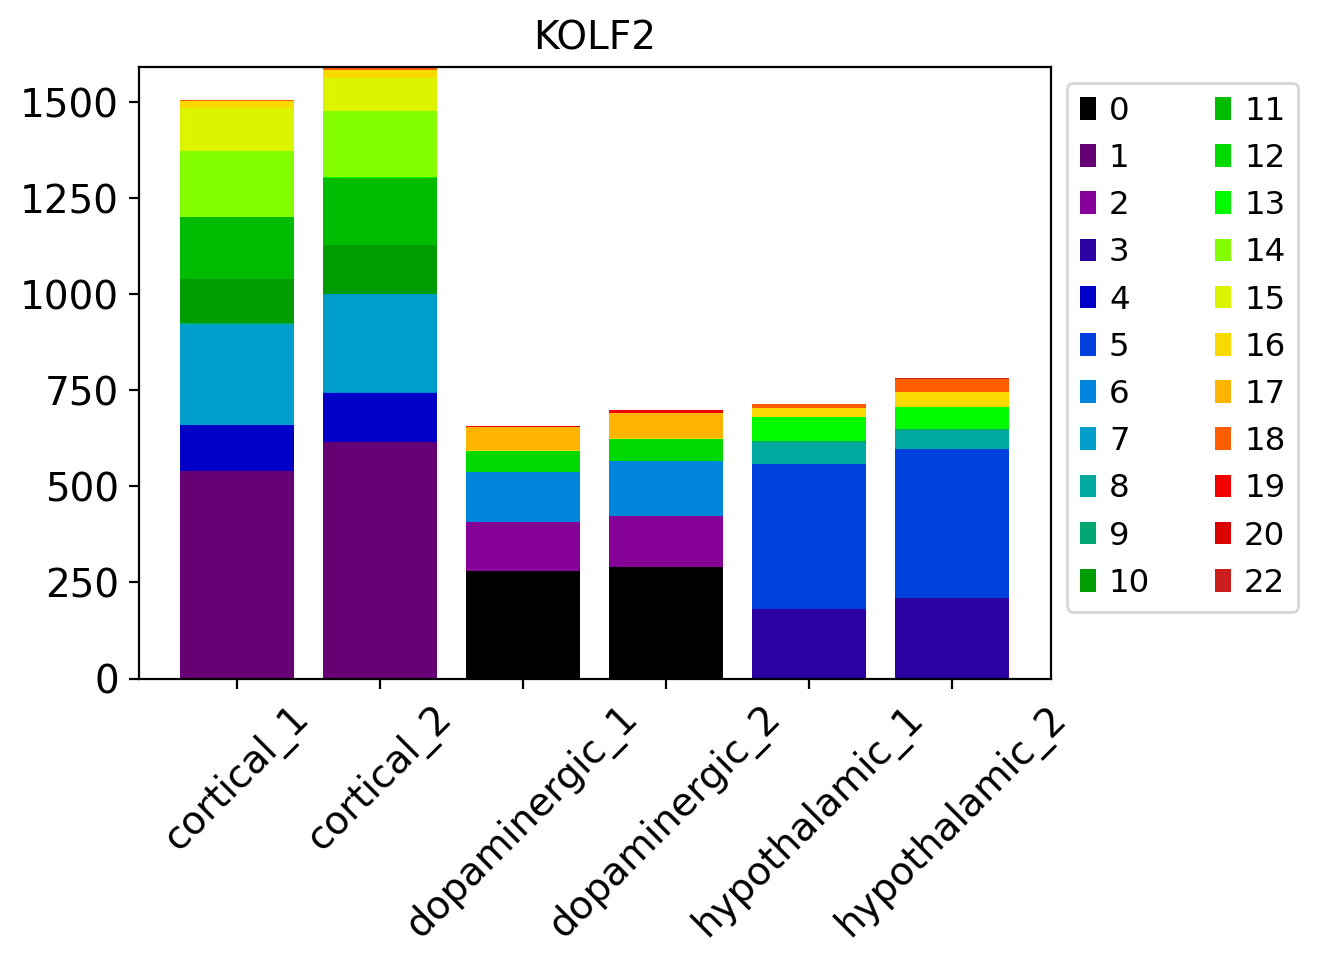

In [103]:
# draw stack bar
draw_stackbar(df_cluster2, "KOLF2")

In [155]:
df_cluster.head()

batch,cortical_1,cortical_2,dopaminergic_1,dopaminergic_2,hypothalamic_1,hypothalamic_2
leiden,,,,,,
0,0,0,279,291,0,0
1,541,616,0,0,0,0
2,0,0,128,133,0,0
3,0,0,0,0,180,210
4,118,128,0,0,0,0


###Combined duplicates

In [0]:
# combined duplicates

In [0]:
df_cluster.index = df_cluster.index.astype(list)
df_cluster.columns = df_cluster.columns.astype(list)

In [0]:
df_cluster["cortical"] = df_cluster.cortical_1 + df_cluster.cortical_2
df_cluster["dopaminergic"] = df_cluster.dopaminergic_1 + df_cluster.dopaminergic_2
df_cluster["hypothalamic"] = df_cluster.hypothalamic_1 + df_cluster.hypothalamic_2

In [0]:
df_cluster3 = df_cluster.iloc[:, 6:9 ]

In [159]:
df_cluster3.head()

batch,cortical,dopaminergic,hypothalamic
leiden,,,
0,0,570,0
1,1157,0,0
2,0,261,0
3,0,0,390
4,246,0,0


In [192]:
df_cluster2 = df_kolf2.pivot_table(index="batch", columns="leiden", values = "cell", aggfunc="count").fillna(0).astype("int")
df_cluster2

leiden,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,22
batch,,,,,,,,,,,,,,,,,,,,,,
cortical_1,0,541,0,0,118,0,0,261,1,4,114,162,0,0,170,113,19,0,2,0,0,0
cortical_2,0,616,0,0,128,0,1,255,0,1,127,175,0,1,171,88,19,0,10,0,0,0
dopaminergic_1,279,0,128,0,0,0,131,0,0,0,0,0,54,0,0,0,3,59,0,2,0,0
dopaminergic_2,291,0,133,0,0,0,142,0,0,0,0,0,57,0,0,0,3,64,0,8,1,0
hypothalamic_1,0,0,0,180,0,378,0,0,55,4,0,0,0,62,0,0,24,0,11,0,0,0
hypothalamic_2,0,0,0,210,0,387,0,0,47,4,0,0,0,57,1,0,39,0,35,0,0,1


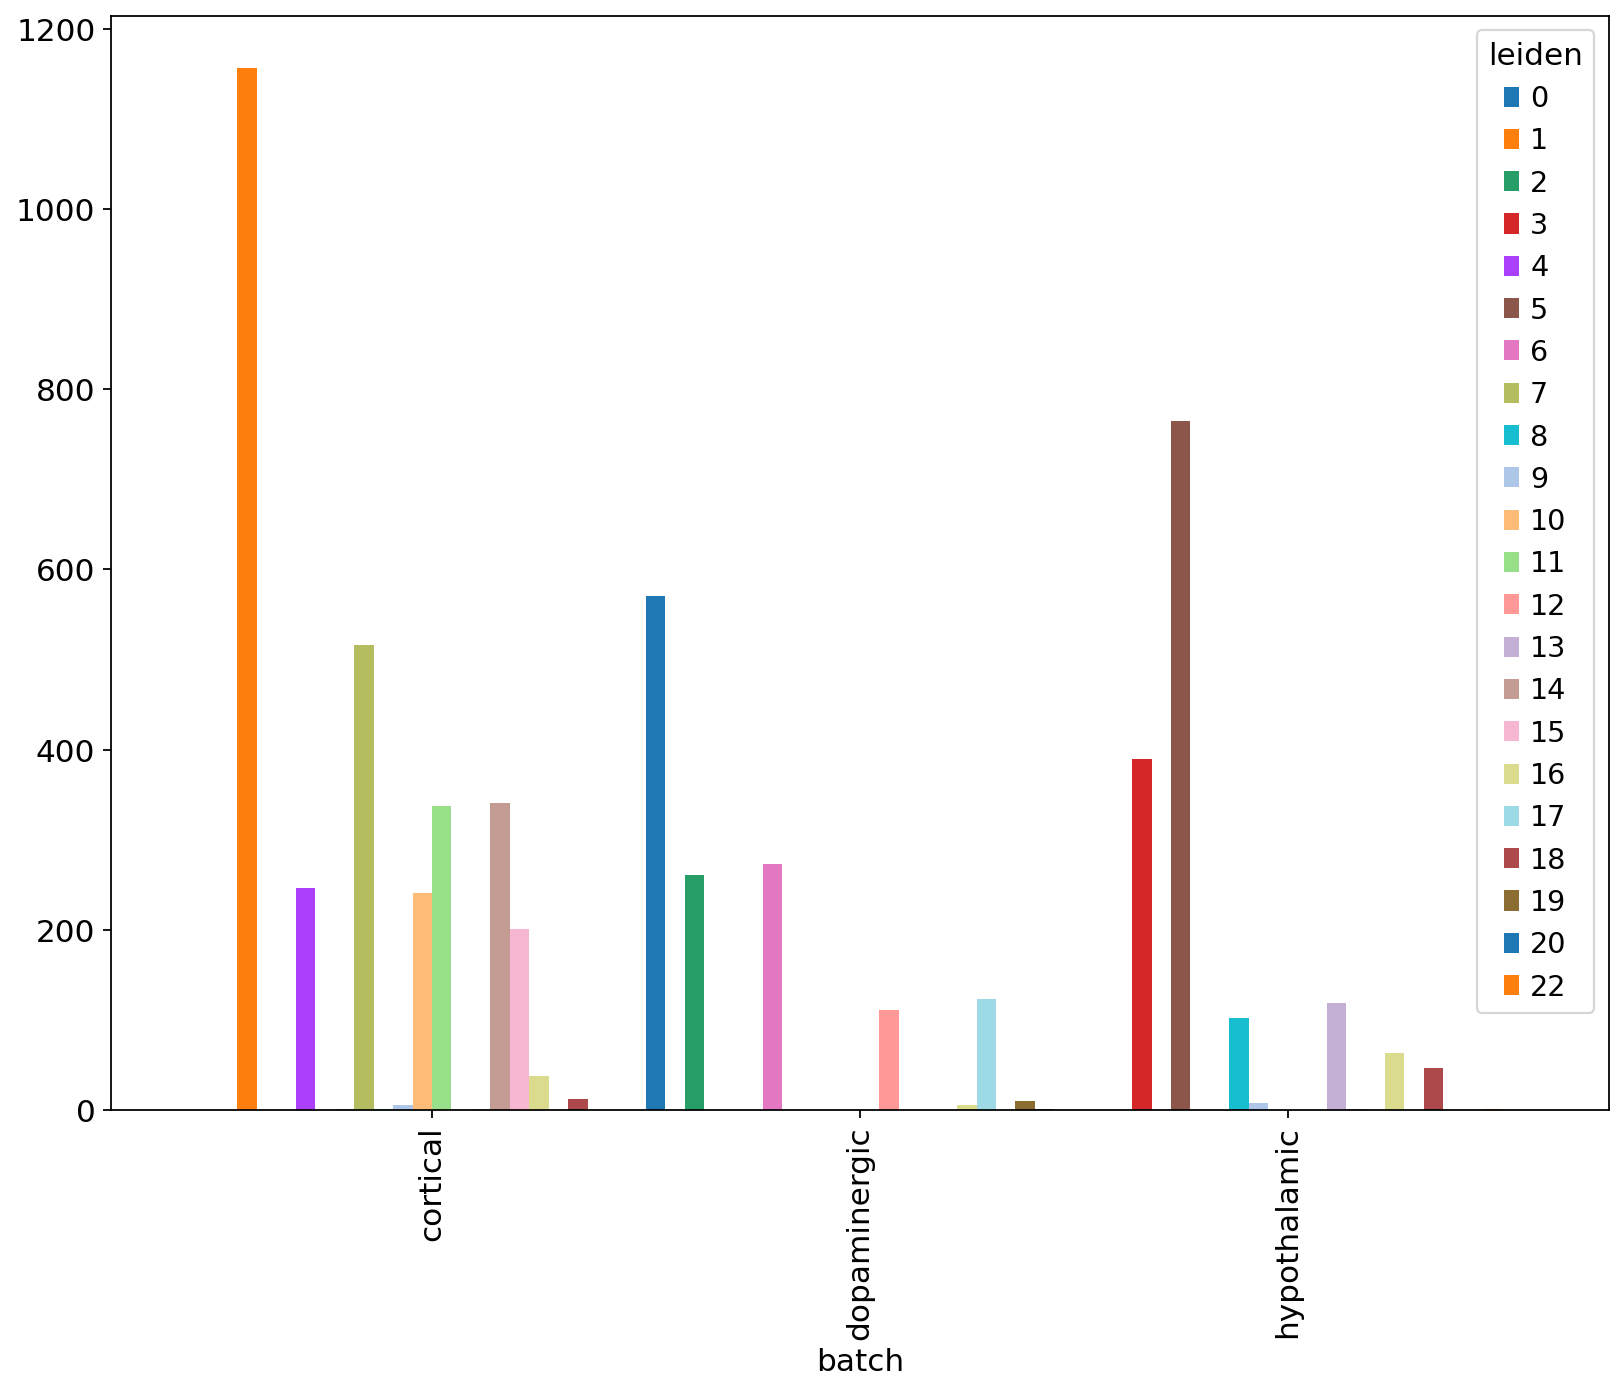

In [165]:
df_cluster3.T.plot(kind="bar", figsize = (12,9), grid=False, width=1)

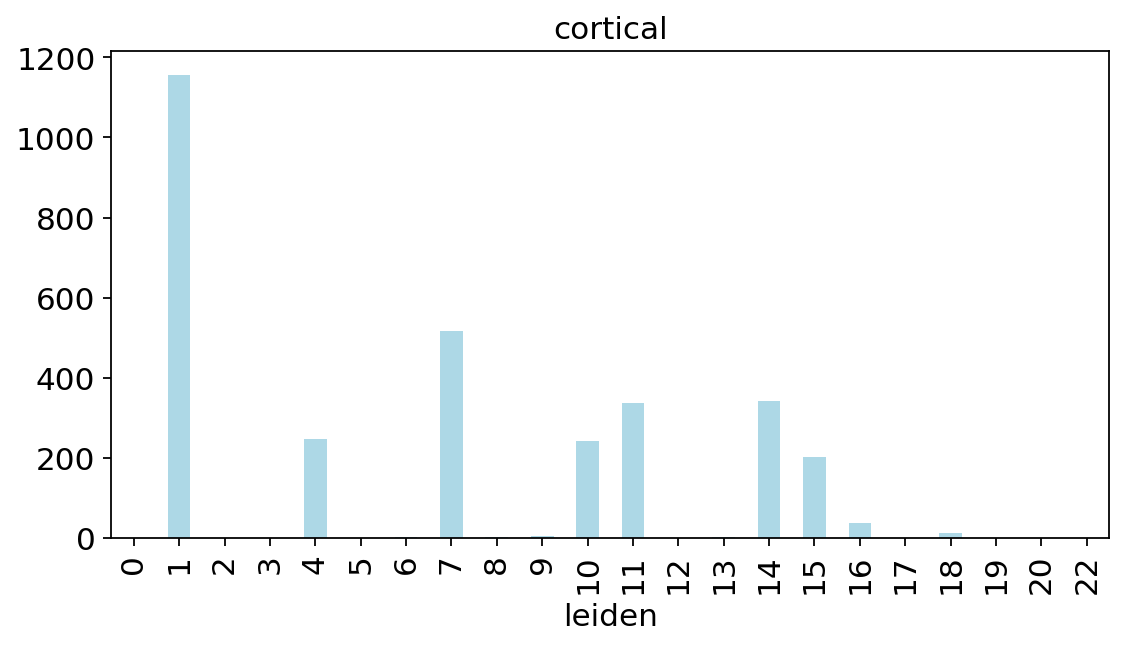

In [136]:
df_cluster3.cortical.plot(kind="bar", figsize = (8,4), grid=False, color="lightblue", title="cortical")

In [168]:
#s.sort_values(ascending=False)
df_cluster3.cortical.sort_values(ascending=False)

leiden
1     1157
7      516
14     341
11     337
4      246
10     241
15     201
16      38
18      12
9        5
13       1
8        1
6        1
5        0
2        0
3        0
22       0
20       0
12       0
17       0
19       0
0        0
Name: cortical, dtype: int64

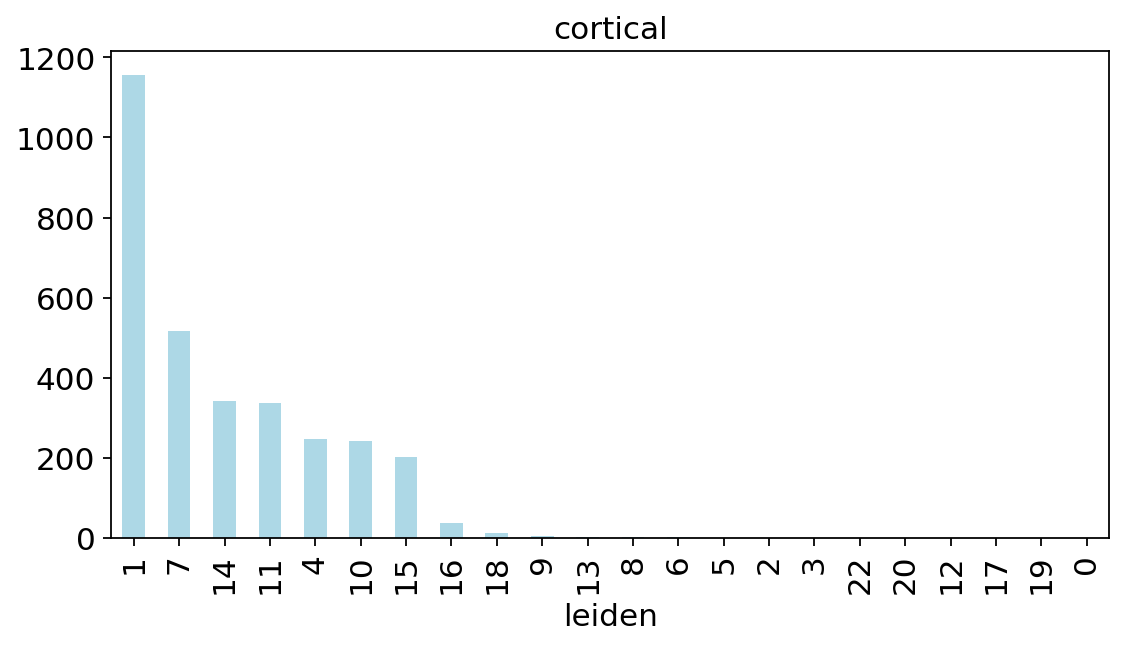

In [170]:
df_cluster3.cortical.sort_values(ascending=False).plot(kind="bar", figsize = (8,4), grid=False, color="lightblue", title="cortical")

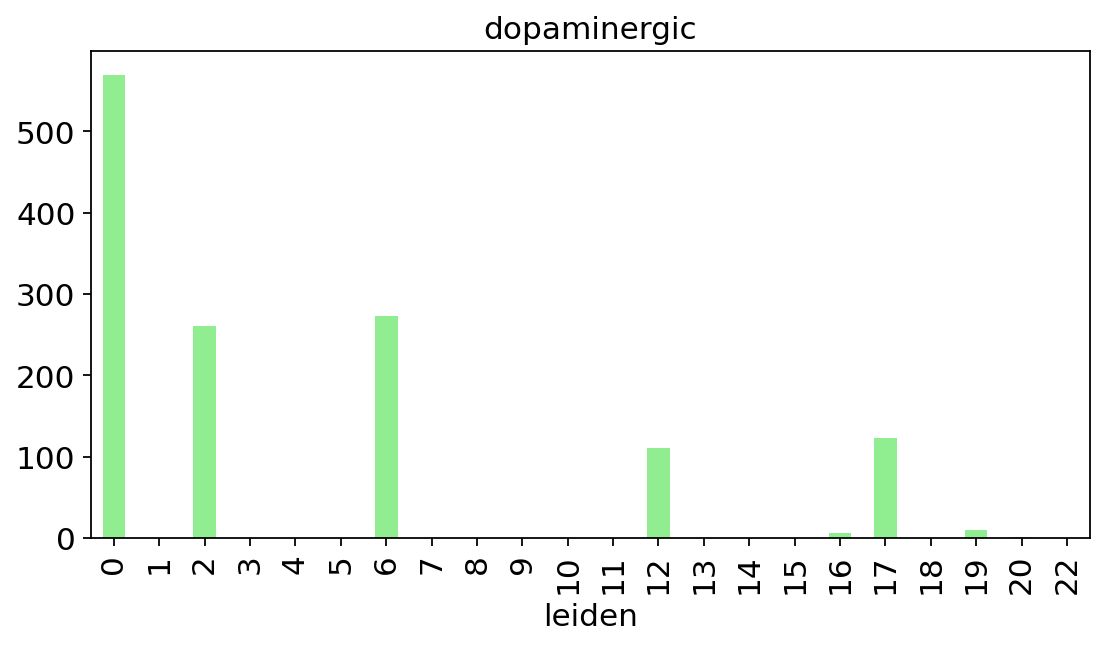

In [160]:
df_cluster3.dopaminergic.plot(kind="bar", figsize = (8,4), grid=False, color="lightgreen", title="dopaminergic")

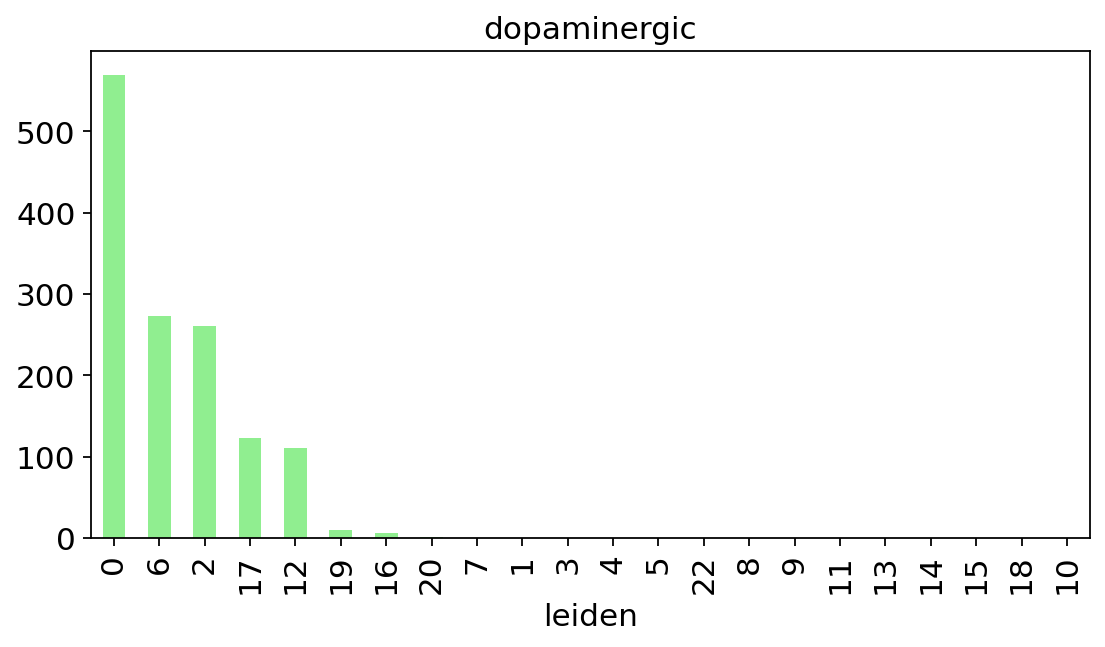

In [171]:
df_cluster3.dopaminergic.sort_values(ascending=False).plot(kind="bar", figsize = (8,4), grid=False, color="lightgreen", title="dopaminergic")

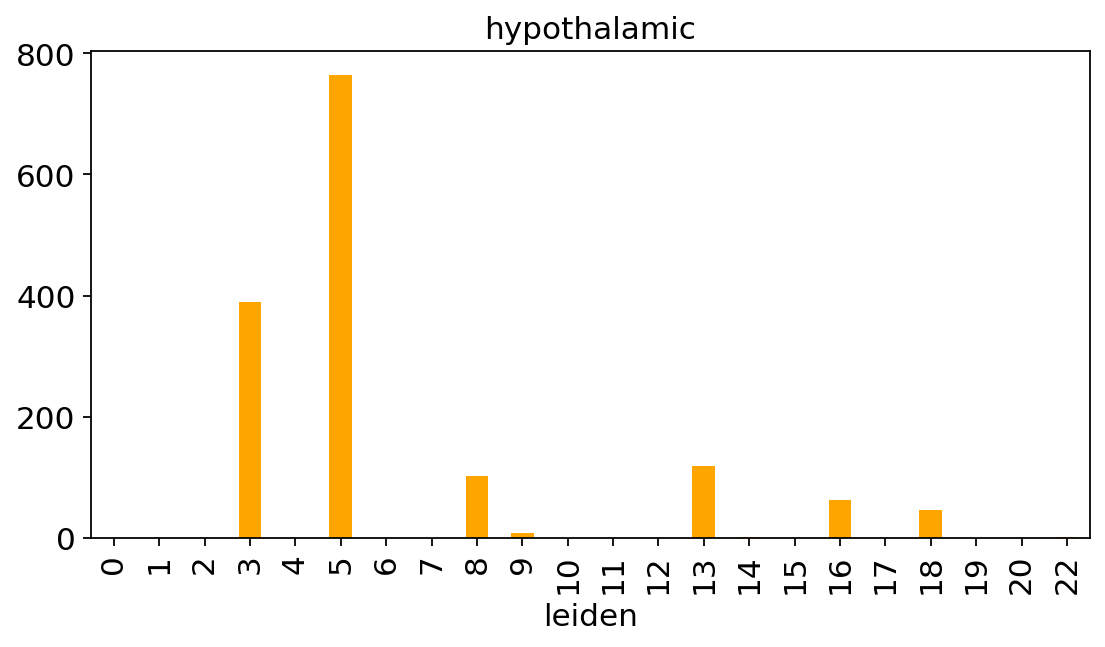

In [161]:
df_cluster3.hypothalamic.plot(kind="bar", figsize = (8,4), grid=False, color="orange", title="hypothalamic")

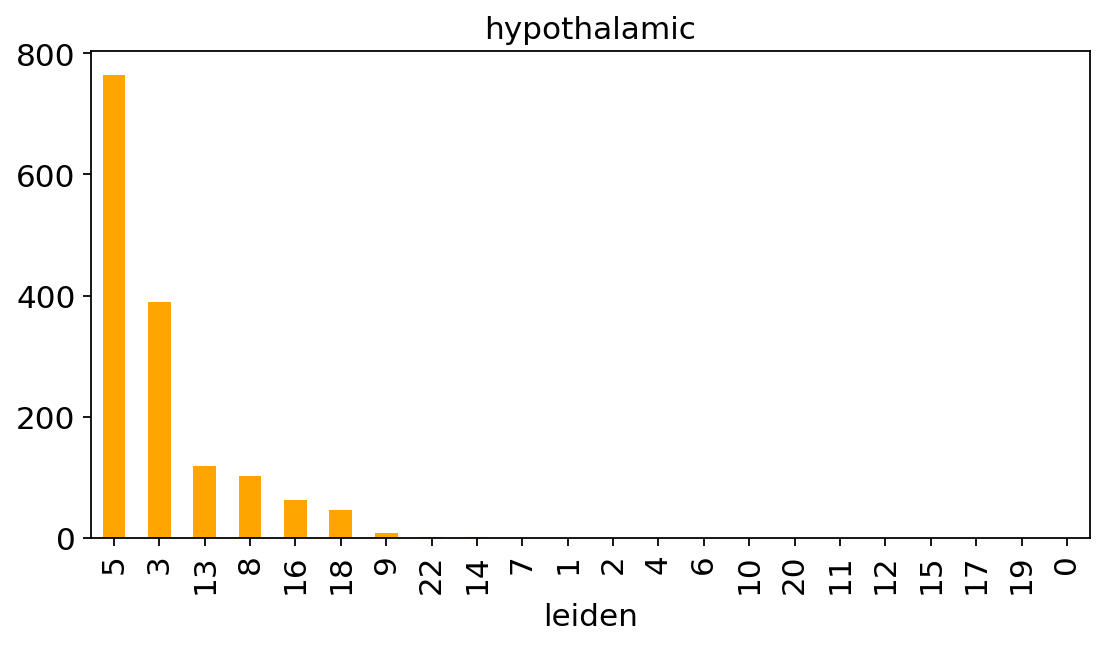

In [172]:
df_cluster3.hypothalamic.sort_values(ascending=False).plot(kind="bar", figsize = (8,4), grid=False, color="orange", title="hypothalamic")

# Use function to generate a preliminary dataframe

In [0]:
# define function to generate a dataframe from adata
def get_df(adata, leiden):
  df = adata.obs.loc[:, ["donor_label","batch", leiden]]
  df["leiden"] = df[leiden]
  df = df.reset_index()
  df.drop(["index",leiden], axis=1, inplace=True)
  print(df.shape)
  return df


In [12]:
df = get_df(adata, "leiden_0.6")

(60832, 3)


In [13]:
df.head()

,donor_label,batch,leiden
0,LNGPI1-C1,cortical_1,15
1,NN0003932-C3,cortical_1,14
2,PGP1-C2,cortical_1,4
3,PGP1-C2,cortical_1,4
4,KOLF2-ARID2-A02,cortical_1,1


# Generate individual dataframe for a specific batch or sample

In [0]:
# generate a separate dataframe for the sake of viualization
batch_name =['cortical_1','cortical_2','dopaminergic_1','dopaminergic_2','hypothalamic_1','hypothalamic_2']
df_list = []

for batch in batch_name:
  df_sub = df[df["batch"] == batch]
  #groupby auto generate index column and aslo generate the column value from aggregation function
  df_sub = df_sub.groupby(["donor_label", "leiden"]).count().sort_index()
  df_sub = df_sub.unstack().fillna(0).astype("int")
  # remove out level of columns
  df_sub.columns = df_sub.columns.droplevel(level = 0)
  new_column_name = ["cluster" + s for s in df_sub.columns.to_list()]
  df_sub.columns = new_column_name
  #only keep 8 clusters
  df_sub=df_sub.iloc[0:7, :]
  df_list.append(df_sub)

df_cor1, df_cor2, df_do1, df_do2, df_hy1, df_hy2 = df_list

In [0]:
df_concat = pd.concat([df_cor1, df_cor2, df_do1, df_do2, df_hy1, df_hy2], axis = 0, keys=batch_name)

In [190]:
!pwd

/content/drive/Shared drives/CARD/projects/iNDI/line_prioritization/projects_lirong/Florian_data


In [0]:
df_concat.to_csv("counts.csv")

In [16]:
df_cor1

,cluster0,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,cluster7,cluster8,cluster9,cluster10,cluster11,cluster12,cluster13,cluster14,cluster15,cluster16,cluster17,cluster18,cluster19,cluster20,cluster21,cluster22
donor_label,,,,,,,,,,,,,,,,,,,,,,,
KOLF2-ARID2-A02,0,541,0,0,118,0,0,261,1,4,114,162,0,0,170,113,19,0,2,0,0,0,0
KUCG3-C1,0,36,0,0,14,0,0,15,0,1,14,6,0,0,7,2,0,0,0,0,0,0,0
LNGPI1-C1,0,41,1,1,46,0,0,35,3,3,49,29,0,0,197,467,14,0,0,0,0,2,0
NCRM1-C6,0,184,0,0,219,0,0,125,0,0,103,146,0,0,48,10,7,0,0,0,0,0,0
NCRM5-C5,0,472,0,0,206,0,0,181,0,1,166,93,0,0,43,13,10,0,3,0,0,0,0
NN0003932-C3,0,780,1,0,333,0,0,305,2,2,257,133,0,3,168,52,15,0,5,0,0,0,0
PGP1-C2,0,599,0,0,671,0,0,484,0,2,297,375,0,1,105,39,11,0,2,0,0,0,0


In [0]:
# generate dataframe for each experiment
batchs = ["cortical", "dopaminergic", "hypothalamic"]
df_list2 = []
for batch in batchs:
  df_sub = df[df["batch"].str.contains(batch)]
  #groupby auto generate index column and aslo generate the column value from aggregation function
  df_sub = df_sub.groupby(["donor_label", "leiden"]).count().sort_index()
  df_sub = df_sub.unstack().fillna(0).astype("int")
  # remove out level of columns
  df_sub.columns = df_sub.columns.droplevel(level = 0)
  df_sub = df_sub.iloc[0:7, :]
  new_column_name = ["cluster" + s for s in df_sub.columns.to_list()]
  df_sub.columns = new_column_name
  df_list2.append(df_sub)

df_cor, df_do, df_hy = df_list2

In [0]:
df2_concat = pd.concat([df_cor, df_do, df_hy], axis = 0, keys=batchs)

In [0]:
df2_concat.to_csv("counts_2.csv")

# Draw stack bars using functions

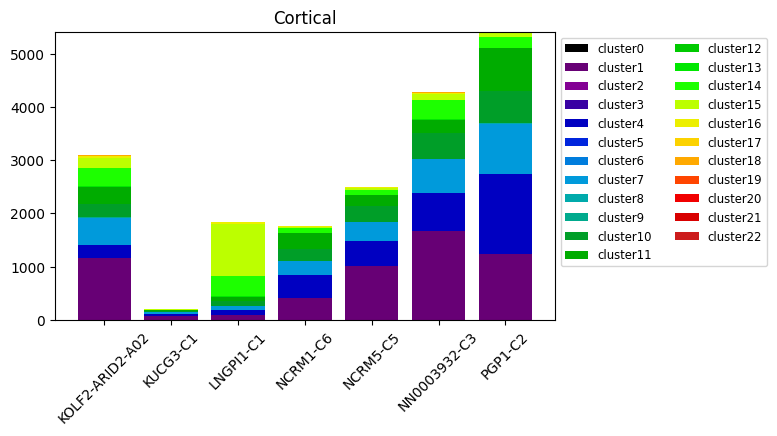

In [206]:
draw_stackbar(df_cor, "Cortical")

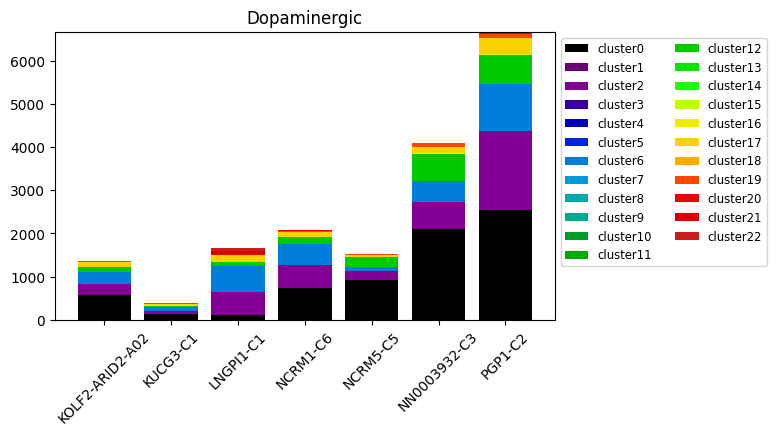

In [207]:
draw_stackbar(df_do, "Dopaminergic")

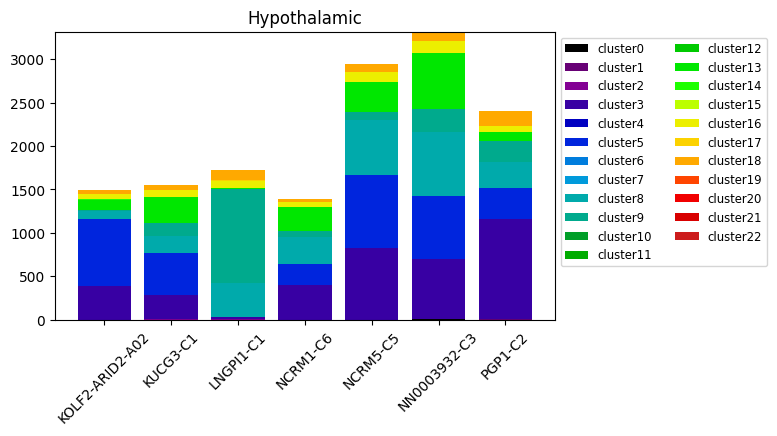

In [209]:
draw_stackbar(df_hy, "Hypothalamic")

# draw figures using percenatage

In [0]:
# covert count to percentage
def cal_percent(df):
  # covert categorical into list type
  df.columns = df.columns.astype(list)
  df["total"] = df.sum(axis=1)
  for col in df.columns.to_list():
    df[col] = df[col]*100/df["total"]
  df.drop("total", axis = 1, inplace= True)
  return df

In [0]:
df_list3 = []
for i in range(len(df_list2)):
  #df = sample_name + str(i)
  #print(df)
  df = cal_percent(df_list2[i])
  df_list3.append(df)

df_cor_per, df_do_per, df_hy_per = df_list3

In [248]:
batchs

['cortical', 'dopaminergic', 'hypothalamic']

In [0]:
df_all_per = pd.concat(df_list3, keys=batchs)
df_all_per.to_csv("percentage.csv")

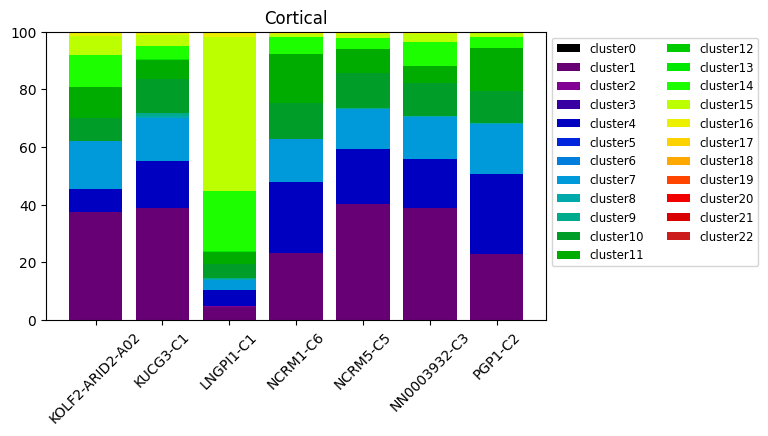

In [258]:
draw_stackbar(df_cor_per, "Cortical")

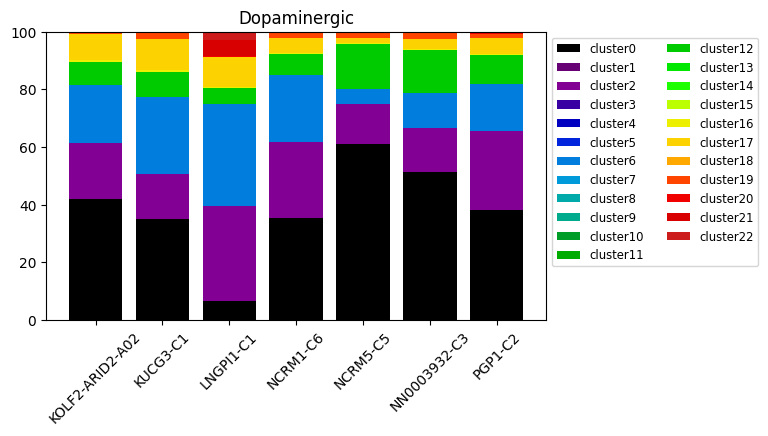

In [259]:
draw_stackbar(df_do_per, "Dopaminergic")

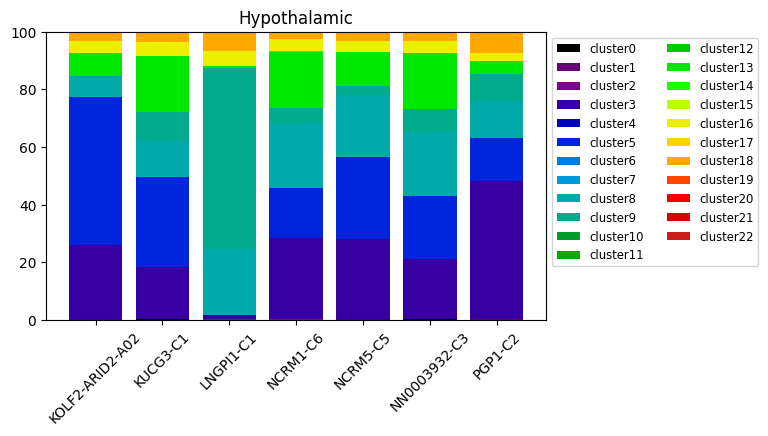

In [261]:
draw_stackbar(df_hy_per, "Hypothalamic")

In [0]:
draw_stackbar(df_cor_per, "Cortical")

In [0]:
df_cor_copy = df_cor.copy()

In [0]:
# tips: the dataframe bececome categoricalindex, which will cause problem in adding columns or reset_index
# so have to covert categorical into list type
df_cor_copy.columns = df_cor_copy.columns.astype(list)
df_cor_copy["total"] = df_cor_copy.sum(axis=1)



In [171]:
df_cor_copy

leiden,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,total
donor_label,,,,,,,,,,,,,,,,,,,,,,,,
KOLF2-ARID2-A02,0,1157,0,0,246,0,1,516,1,5,241,337,0,1,341,201,38,0,12,0,0,0,0,3097
KUCG3-C1,0,78,0,0,33,0,0,30,1,2,24,13,0,1,9,8,1,0,1,0,0,0,0,201
LNGPI1-C1,0,82,5,2,103,0,0,65,3,5,92,78,0,5,386,979,32,0,2,0,0,2,0,1841
NCRM1-C6,0,408,0,0,433,0,0,261,0,0,221,300,0,0,102,19,11,0,1,0,0,0,0,1756
NCRM5-C5,0,1003,0,0,475,0,0,354,0,1,307,207,0,1,93,41,13,0,3,0,0,0,0,2498
NN0003932-C3,0,1665,1,0,717,0,0,632,3,2,490,253,0,7,353,117,28,0,7,0,0,0,0,4275
PGP1-C2,0,1229,0,0,1516,0,0,943,1,2,617,796,0,1,210,68,27,0,2,0,0,0,0,5412
donor7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
for col in df_cor_copy.columns.to_list():
  df_cor_copy[col] = df_cor_copy[col]/df_cor_copy["total"]


In [0]:
df_cor_copy.drop("total", axis = 1, inplace= True)

In [177]:
df_cor_copy

leiden,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
donor_label,,,,,,,,,,,,,,,,,,,,,,,
KOLF2-ARID2-A02,0.0,0.373587,0.000000,0.000000,0.079432,0.0,0.000323,0.166613,0.000323,0.001614,0.077817,0.108815,0.0,0.000323,0.110107,0.064902,0.012270,0.0,0.003875,0.0,0.0,0.000000,0.0
KUCG3-C1,0.0,0.388060,0.000000,0.000000,0.164179,0.0,0.000000,0.149254,0.004975,0.009950,0.119403,0.064677,0.0,0.004975,0.044776,0.039801,0.004975,0.0,0.004975,0.0,0.0,0.000000,0.0
LNGPI1-C1,0.0,0.044541,0.002716,0.001086,0.055948,0.0,0.000000,0.035307,0.001630,0.002716,0.049973,0.042368,0.0,0.002716,0.209669,0.531776,0.017382,0.0,0.001086,0.0,0.0,0.001086,0.0
NCRM1-C6,0.0,0.232346,0.000000,0.000000,0.246583,0.0,0.000000,0.148633,0.000000,0.000000,0.125854,0.170843,0.0,0.000000,0.058087,0.010820,0.006264,0.0,0.000569,0.0,0.0,0.000000,0.0
NCRM5-C5,0.0,0.401521,0.000000,0.000000,0.190152,0.0,0.000000,0.141713,0.000000,0.000400,0.122898,0.082866,0.0,0.000400,0.037230,0.016413,0.005204,0.0,0.001201,0.0,0.0,0.000000,0.0
NN0003932-C3,0.0,0.389474,0.000234,0.000000,0.167719,0.0,0.000000,0.147836,0.000702,0.000468,0.114620,0.059181,0.0,0.001637,0.082573,0.027368,0.006550,0.0,0.001637,0.0,0.0,0.000000,0.0
PGP1-C2,0.0,0.227088,0.000000,0.000000,0.280118,0.0,0.000000,0.174242,0.000185,0.000370,0.114006,0.147081,0.0,0.000185,0.038803,0.012565,0.004989,0.0,0.000370,0.0,0.0,0.000000,0.0
donor7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
draw_stackbar(df_cor_copy, "cortical")

In [0]:
df_cor_copy.index = df_cor_copy.index.astype(list)
f_cor_copy.reset_index(inplace=True)

In [129]:
df['Total'] = df.sum(axis=1)
df_cor.sum(axis=1).values

array([3097,  201, 1841, 1756, 2498, 4275, 5412,    0])

In [0]:
df_cor1.index.values

[KOLF2-ARID2-A02, KUCG3-C1, LNGPI1-C1, NCRM1-C6, NCRM5-C5, NN0003932-C3, PGP1-C2, donor7]
Categories (11, object): [KOLF2-ARID2-A02, KUCG3-C1, LNGPI1-C1, NCRM1-C6, ..., donor7, doublet, nan,
                          unassigned]

In [0]:
#subset using batch first
#df_cor = df[df["batch"].isin(["cortical_2", "cortical_1"])]

# Use simple bar to visualize the data

For this case: calculate protocol of "cortical' and for the donor of KDLF2

In [0]:
df_cor["total_cell"] = df_cor["cell_count"].sum()
df_cor["percentage_per_cluster"] = df_cor["cell_count"]/df_cor["total_cell"]
df_cor.head()

,cell_count,total_cell,percentage_per_cluster
leiden,,,
0,0,1505,0.000000
1,541,1505,0.359468
2,0,1505,0.000000
3,0,1505,0.000000
4,118,1505,0.078405


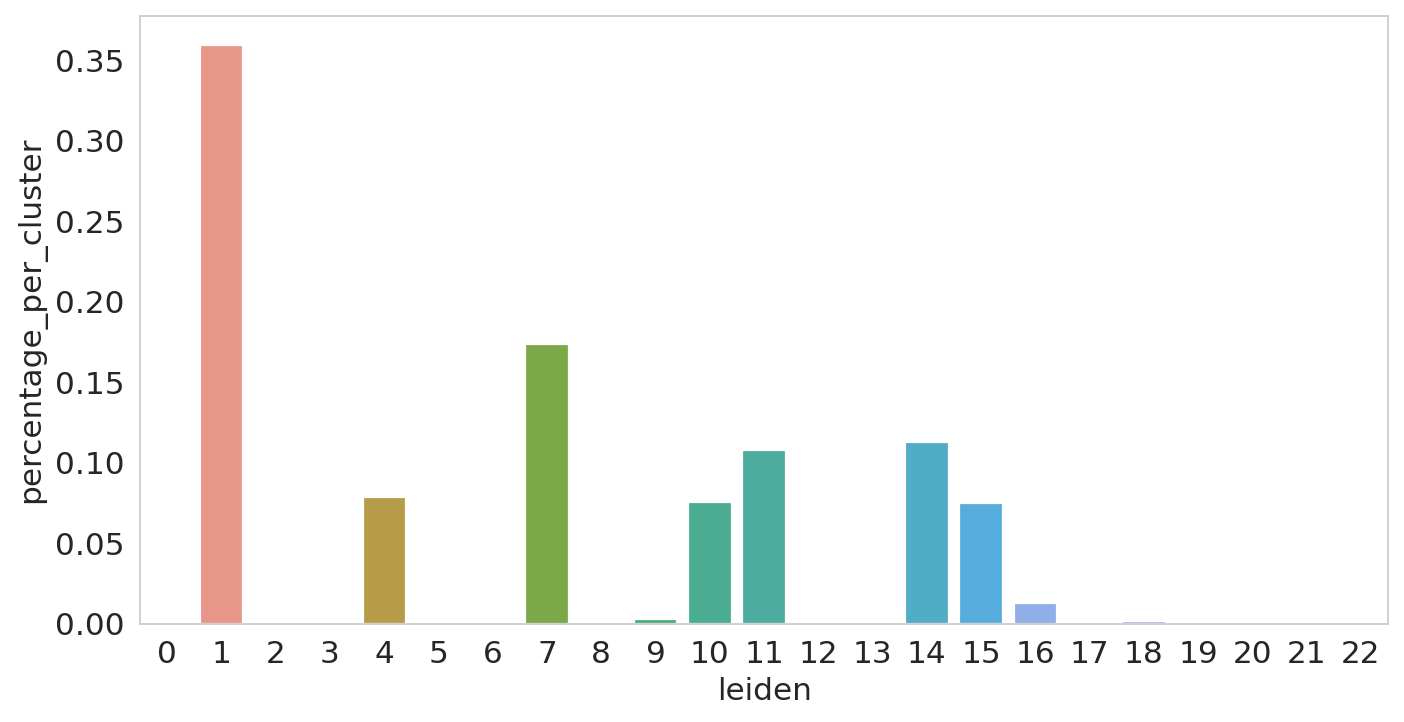

In [0]:
plt.figure(figsize=(10,5))
sns.set_style("whitegrid", {'axes.grid' : False})
sns.barplot(x=df_cor.index, y = "percentage_per_cluster", data=df_cor)
ylim = (0,1)

In [0]:
df.index.to_flat_index

<bound method Index.to_flat_index of RangeIndex(start=0, stop=60832, step=1)>

In [0]:
df.donor_label.value_counts().index.tolist()

In [0]:
df.leiden.value_counts().index.tolist()

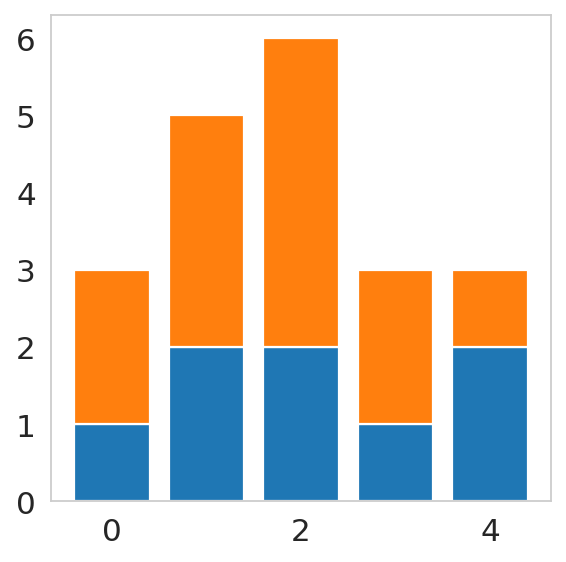

In [0]:
# We use the keyword bottom to do this
# The top bar will have bottom set as height

# First Bar
video_game_hours = [1, 2, 2, 1, 2]
plt.bar(range(len(video_game_hours)),
  video_game_hours)

# Second Bar
book_hours = [2, 3, 4, 2, 1]
plt.bar(range(len(book_hours)),
  book_hours,
  bottom=video_game_hours)

# third bar


# Get each bottom for 3+ bars
sport_hours = np.add(video_game_hours, book_hours)
